In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode (connected = True)
cf.go_offline();
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

In [2]:
data = pd.read_csv('Reviews.csv')
print(data.columns)



Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [3]:
columns_to_drop = ['Time','ProfileName','UserId','HelpfulnessNumerator',
       'HelpfulnessDenominator']
df = data.drop(columns=columns_to_drop)
df = df.head(10000)
print(df.columns)

Index(['Id', 'ProductId', 'Score', 'Summary', 'Text'], dtype='object')


In [4]:
print(df.dtypes)

Id            int64
ProductId    object
Score         int64
Summary      object
Text         object
dtype: object


In [5]:
def missing_values_analysis(df):
  na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
  n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
  ratio_ = ((df[na_columns_].isnull().sum().astype(int)) / df.shape[0] * 100).sort_values(ascending=True)
  missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Missing Values', 'Ratio'])
  missing_df = pd.DataFrame(missing_df)
  return missing_df

def check_dataframe(df, head=5, tail=5):

    print("SHAPE".center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('columns: {}'.format(df.shape[1]))
    print("TYPES".center(82, '~'))
    print(df.dtypes)
    print("".center(82, '~'))
    print(missing_values_analysis(df))
    print('DUPLICATED VALUES'.center(83, '~'))
    print(df.duplicated().sum())


check_dataframe(df)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 10000
columns: 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Id            int64
ProductId    object
Score         int64
Summary      object
Text         object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [Missing Values, Ratio]
Index: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0


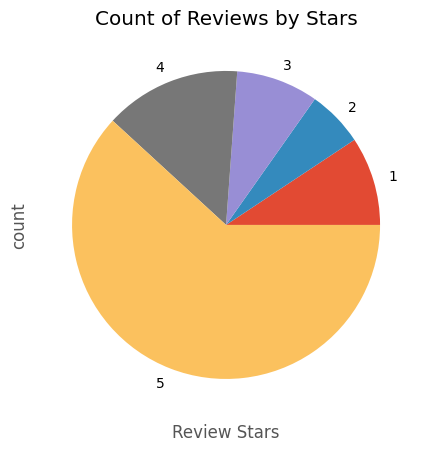

In [6]:

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
plt.style.use('ggplot')
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='pie',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

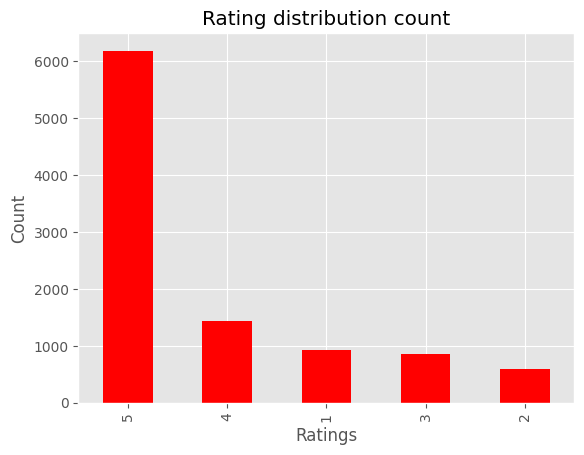

In [7]:
#Bar plot to visualize the total counts of each rating

df['Score'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [8]:
sia = SentimentIntensityAnalyzer()
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
"""" now we have sentiment score and meta deta"""""
print(vaders)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.05it/s]


         Id    neg    neu    pos  compound   ProductId  Score                           Summary                                               Text
0         1  0.000  0.695  0.305    0.9441  B001E4KFG0      5             Good Quality Dog Food  I have bought several of the Vitality canned d...
1         2  0.138  0.862  0.000   -0.5664  B00813GRG4      1                 Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...
2         3  0.091  0.754  0.155    0.8265  B000LQOCH0      4             "Delight" says it all  This is a confection that has been around a fe...
3         4  0.000  1.000  0.000    0.0000  B000UA0QIQ      2                    Cough Medicine  If you are looking for the secret ingredient i...
4         5  0.000  0.552  0.448    0.9468  B006K2ZZ7K      5                       Great taffy  Great taffy at a great price.  There was a wid...
...     ...    ...    ...    ...       ...         ...    ...                               ...                       

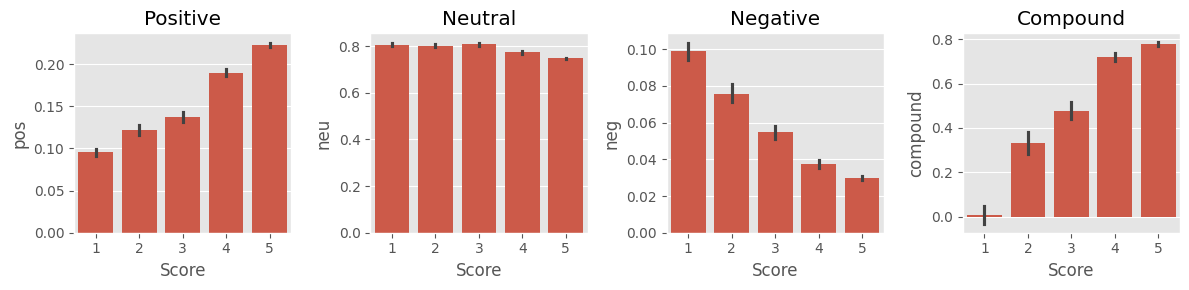

In [9]:
fig, axs = plt.subplots(1,4, figsize=(12,3))
sns.barplot(data=vaders, x='Score', y='pos', ax = axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax = axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax =axs[2])
sns.barplot(data=vaders, x='Score', y='compound', ax =axs[3])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[3].set_title("Compound")
plt.tight_layout()
plt.show()

In [10]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{df['Score'].value_counts()}")

Rating value count: 
Score
5    6183
4    1433
1     932
3     862
2     590
Name: count, dtype: int64


In [11]:
print(vaders.columns)


Index(['Id', 'neg', 'neu', 'pos', 'compound', 'ProductId', 'Score', 'Summary',
       'Text'],
      dtype='object')


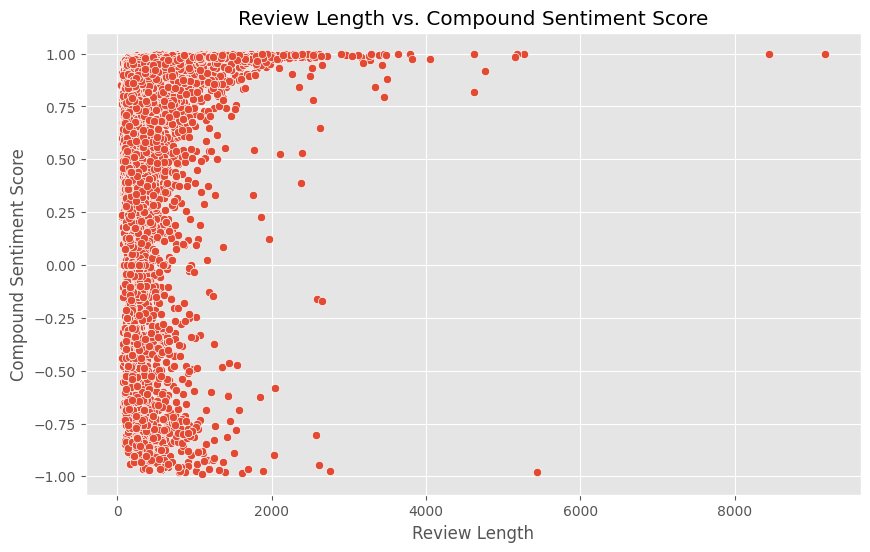

In [12]:
vaders['Review_Length'] = vaders['Text'].apply(len)

# Scatter plot of review length vs. compound sentiment score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Review_Length', y='compound', data=vaders)
plt.title('Review Length vs. Compound Sentiment Score')
plt.xlabel('Review Length')
plt.ylabel('Compound Sentiment Score')
plt.show()

In [13]:
highly_positive_reviews = vaders[vaders['compound'] >= 0.9]
# You can adjust the threshold (e.g., 0.9) to capture reviews with slightly lower scores if needed

# Filter reviews with compound score close to -1 (highly negative)
highly_negative_reviews = vaders[vaders['compound'] <= -0.9]
# You can adjust the threshold (e.g., -0.9) to capture reviews with slightly higher scores if needed

# Display highly positive reviews
print("Highly Positive Reviews:")
print(highly_positive_reviews[['Text', 'compound']])

# Display highly negative reviews
print("\nHighly Negative Reviews:")
print(highly_negative_reviews[['Text', 'compound']])

Highly Positive Reviews:
                                                   Text  compound
0     I have bought several of the Vitality canned d...    0.9441
4     Great taffy at a great price.  There was a wid...    0.9468
6     This saltwater taffy had great flavors and was...    0.9346
7     This taffy is so good.  It is very soft and ch...    0.9487
10    I don't know if it's the cactus or the tequila...    0.9746
...                                                 ...       ...
9989  I am not a great milk producer and ha e had to...    0.9222
9990  Great product, our daughter loves this and has...    0.9841
9991  This is a good product and very high-quality. ...    0.9632
9997  I wanted to solely breastfeed but was unable t...    0.9305
9999  We have a 7 week old... He had gas and constip...    0.9850

[3763 rows x 2 columns]

Highly Negative Reviews:
                                                   Text  compound
67    I purchased the Mango flavor, and to me it doe...   -0.9116


                pos           neg           neu      compound
count  10000.000000  10000.000000  10000.000000  10000.000000
mean       0.192948      0.042308      0.764743      0.645819
std        0.105562      0.052573      0.100691      0.464849
min        0.000000      0.000000      0.291000     -0.987500
25%        0.117000      0.000000      0.701000      0.585850
50%        0.181000      0.027000      0.774000      0.849500
75%        0.260000      0.066000      0.836000      0.937825
max        0.709000      0.377000      1.000000      0.999700


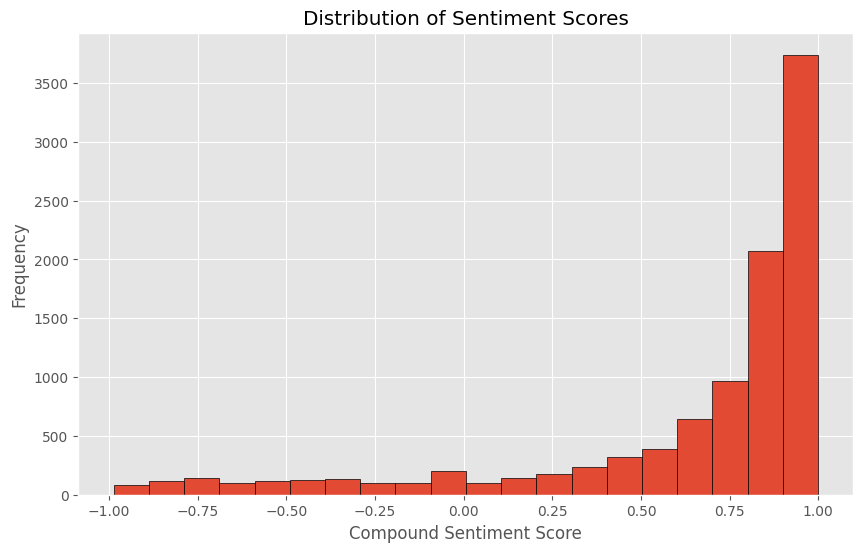

In [14]:
# Summary statistics of sentiment scores
sentiment_summary = vaders[['pos', 'neg', 'neu', 'compound']].describe()
print(sentiment_summary)

# Visualizing distribution of compound sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(vaders['compound'], bins=20, edgecolor='black')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

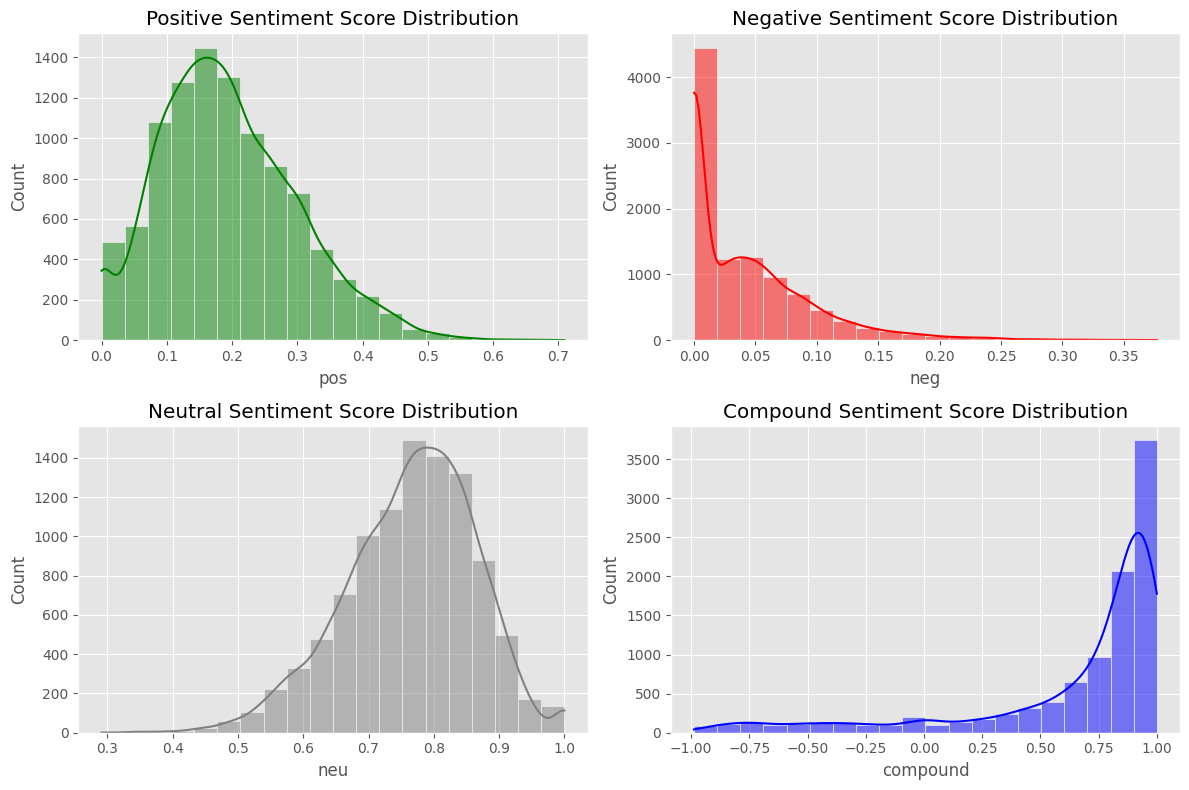

In [15]:
plt.figure(figsize=(12, 8))

# Positive sentiment histogram
plt.subplot(2, 2, 1)
sns.histplot(vaders['pos'], bins=20, kde=True, color='green')
plt.title('Positive Sentiment Score Distribution')

# Negative sentiment histogram
plt.subplot(2, 2, 2)
sns.histplot(vaders['neg'], bins=20, kde=True, color='red')
plt.title('Negative Sentiment Score Distribution')

# Neutral sentiment histogram
plt.subplot(2, 2, 3)
sns.histplot(vaders['neu'], bins=20, kde=True, color='gray')
plt.title('Neutral Sentiment Score Distribution')

# Compound sentiment histogram
plt.subplot(2, 2, 4)
sns.histplot(vaders['compound'], bins=20, kde=True, color='blue')
plt.title('Compound Sentiment Score Distribution')

plt.tight_layout()
plt.show()

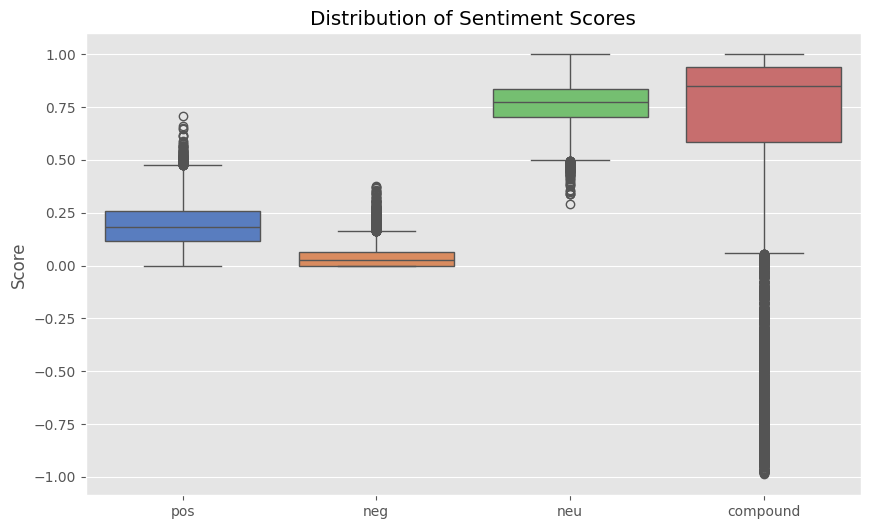

In [16]:
# Plot box plots for sentiment scores (pos, neg, neu, compound)
plt.figure(figsize=(10, 6))

# Positive, Negative, Neutral, and Compound sentiment box plots
sns.boxplot(data=vaders[['pos', 'neg', 'neu', 'compound']], palette='muted')
plt.title('Distribution of Sentiment Scores')
plt.ylabel('Score')

plt.show()


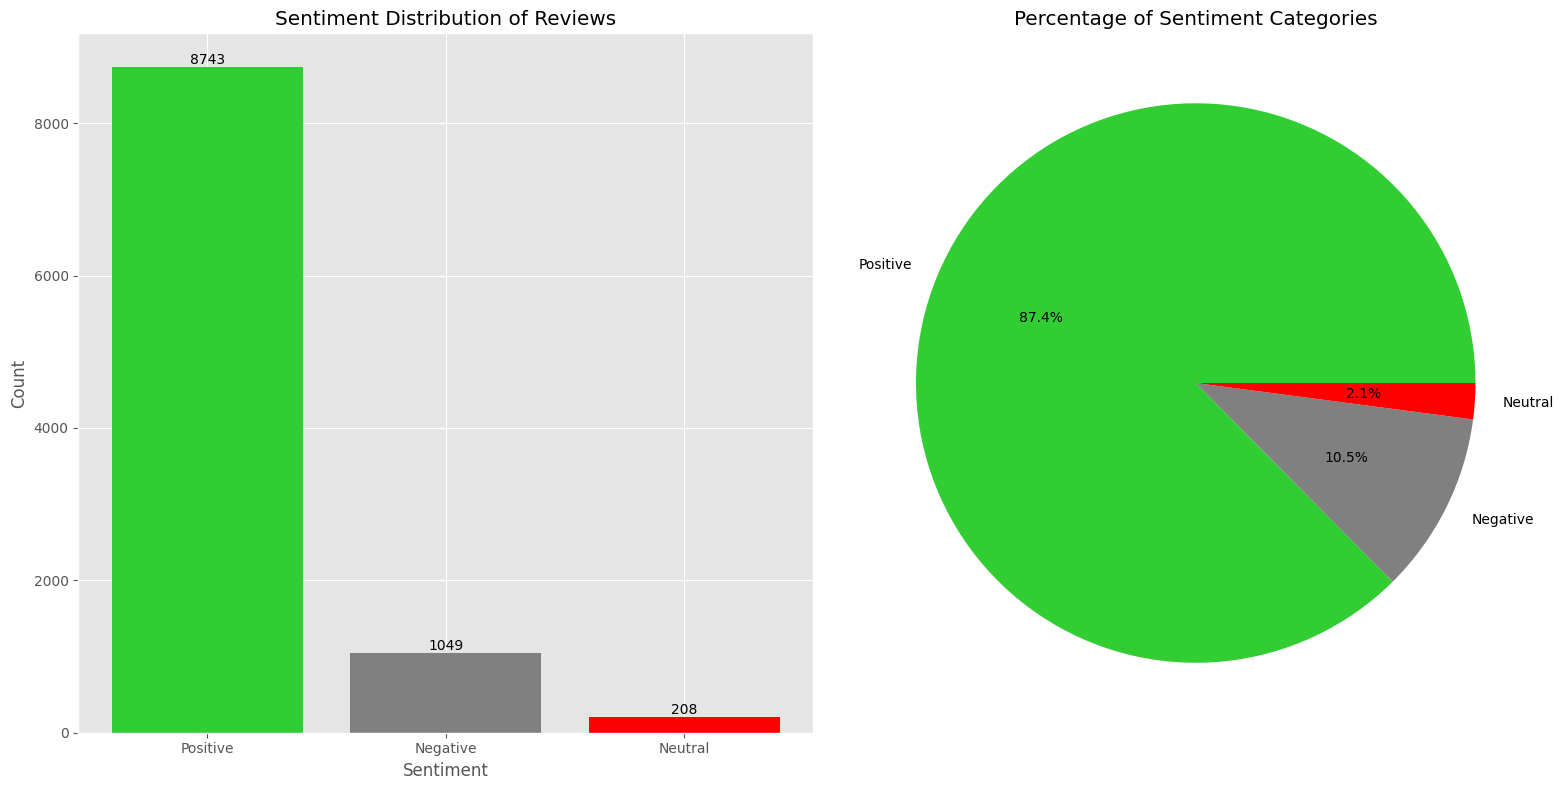

In [17]:
# Define a function to classify sentiment based on compound score
def classify_sentiment(compound_score):
    if compound_score > 0.05:  # Positive sentiment threshold
        return 'Positive'
    elif compound_score < -0.05:  # Negative sentiment threshold
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment classification to each row in the DataFrame
vaders['Sentiment'] = vaders['compound'].apply(classify_sentiment)

# Count the number of Positive, Neutral, and Negative reviews
sentiment_counts = vaders['Sentiment'].value_counts()

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot the bar graph on the first subplot (ax1)
bars = ax1.bar(sentiment_counts.index, sentiment_counts.values, color=['limegreen', 'gray', 'red'])

# Annotate each bar with its numerical value
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.1, yval, ha='center', va='bottom')

ax1.set_title('Sentiment Distribution of Reviews')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.set_xticklabels(sentiment_counts.index, rotation=0)  # Rotate x-axis labels for better readability

# Plot the pie chart on the second subplot (ax2)
ax2.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['limegreen', 'gray', 'red'])
ax2.set_title('Percentage of Sentiment Categories')

# Adjust layout spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
import pandas as pd

# Assuming 'vaders' is your DataFrame containing sentiment scores and text reviews
# Example: vaders = pd.read_csv('your_dataset.csv')

# Define function to categorize sentiment based on compound score
def categorize_sentiment(compound_score, pos_threshold=0.1, neg_threshold=-0.1):
    if compound_score >= pos_threshold:
        return 'Positive'
    elif compound_score <= neg_threshold:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization to each review in the DataFrame
vaders['Sentiment_Category'] = vaders['compound'].apply(categorize_sentiment)

# Count the number of reviews in each sentiment category
sentiment_counts = vaders['Sentiment_Category'].value_counts()

# Display the counts of each sentiment category
print("Sentiment Category Counts:")
print(sentiment_counts)

# Optionally, you can save the updated DataFrame with sentiment categories to a new CSV file
vaders.to_csv('sentiment_categorized_reviews.csv', index=False)


Sentiment Category Counts:
Sentiment_Category
Positive    8694
Negative    1015
Neutral      291
Name: count, dtype: int64


In [19]:
scr = pd.read_csv('sentiment_categorized_reviews.csv')
print(scr.columns)


Index(['Id', 'neg', 'neu', 'pos', 'compound', 'ProductId', 'Score', 'Summary',
       'Text', 'Review_Length', 'Sentiment', 'Sentiment_Category'],
      dtype='object')


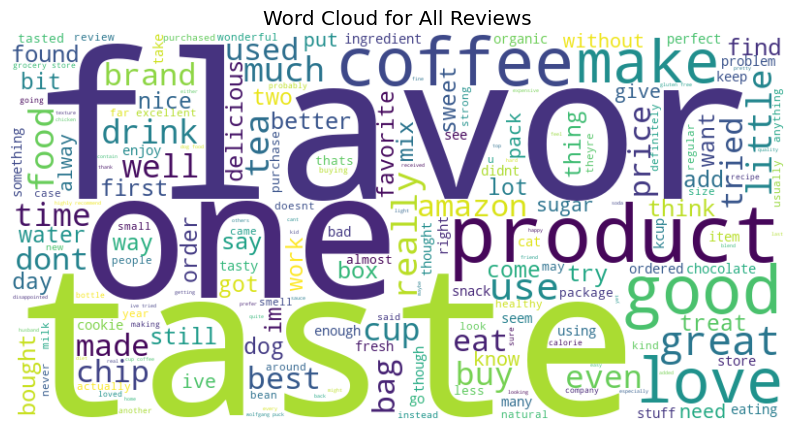

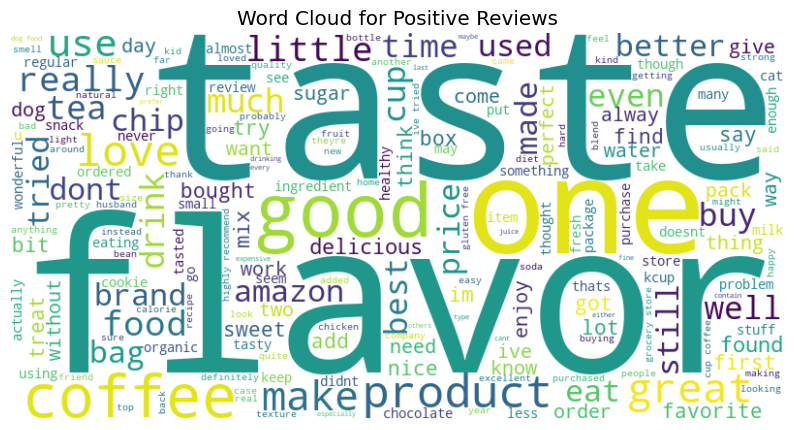

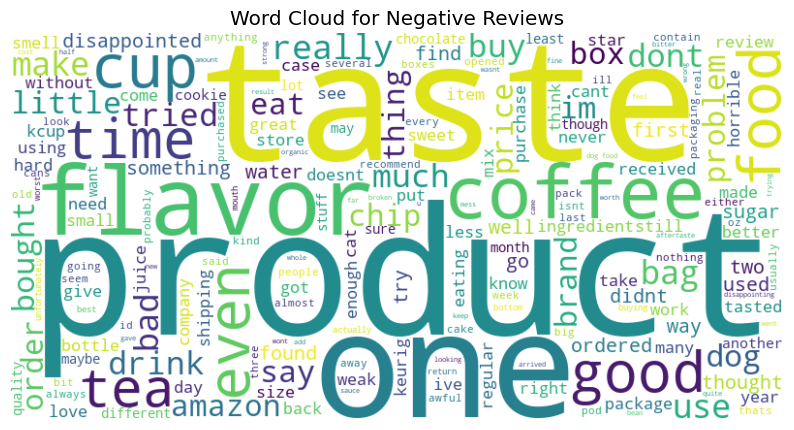

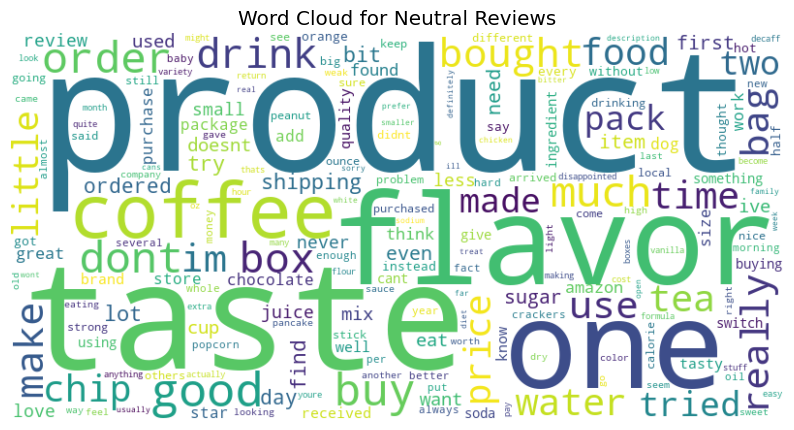

In [20]:
def clean_text(text):
    # Remove HTML tags
    cleaned_text = re.sub(r'<.*?>', ' ', text)
    # Remove non-alphabetic characters and convert to lowercase
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text).lower()
    return cleaned_text

# Apply text cleaning and tokenization
vaders['Cleaned_Text'] = vaders['Text'].apply(clean_text)
vaders['Tokenized_Text'] = vaders['Cleaned_Text'].apply(word_tokenize)

# Filter stopwords
stop_words = set(stopwords.words('english'))
vaders['Filtered_Tokens'] = vaders['Tokenized_Text'].apply(lambda tokens: [token.lower() for token in tokens if token.lower() not in stop_words])

# Function to generate and display word cloud
def generate_wordcloud(tokens, title):
    filtered_text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word cloud for the entire Text column
all_tokens = [token for tokens in vaders['Filtered_Tokens'] for token in tokens]
generate_wordcloud(all_tokens, "Word Cloud for All Reviews")

# Generate word clouds for positive, negative, and neutral reviews
sentiment_categories = ['Positive', 'Negative', 'Neutral']

for category in sentiment_categories:
    category_tokens = [token for tokens in vaders[vaders['Sentiment_Category'] == category]['Filtered_Tokens'] for token in tokens]
    generate_wordcloud(category_tokens, f"Word Cloud for {category} Reviews")

In [21]:
product_sentiment_summary = vaders.groupby('ProductId').agg({
    'pos': 'mean',  # Average positive score
    'neg': 'mean',  # Average negative score
    'neu': 'mean',  # Average neutral score
    'compound': 'mean'  # Average compound score
})

print(product_sentiment_summary)

                 pos       neg       neu  compound
ProductId                                         
B00002NCJC  0.028500  0.131500  0.840000 -0.232650
B00002Z754  0.201000  0.000000  0.799000  0.883600
B00005V3DC  0.195667  0.000000  0.804333  0.719033
B000084DVR  0.374500  0.000000  0.625500  0.984000
B000084E1U  0.034000  0.130000  0.836000 -0.492600
...              ...       ...       ...       ...
B009AVDFCK  0.208000  0.000000  0.792000  0.864700
B009D668KS  0.099000  0.030000  0.871000  0.874800
B009HINRX8  0.217000  0.009333  0.773500  0.928517
B009UOFU20  0.031000  0.074000  0.895000 -0.321100
B009WSNWC4  0.281000  0.000000  0.719000  0.902200

[1422 rows x 4 columns]


In [22]:
product_comparison = vaders[vaders['ProductId'].isin(['B001GVISJM', 'B001EO5QW8'])]
print(product_comparison)

    Id    neg    neu    pos  compound   ProductId  Score                                            Summary                                               Text  Review_Length Sentiment Sentiment_Category                                       Cleaned_Text                                     Tokenized_Text                                    Filtered_Tokens
13  14  0.000  0.355  0.645    0.9466  B001GVISJM      4                                  fresh and greasy!  good flavor! these came securely packed... the...             97  Positive           Positive  good flavor these came securely packed they we...  [good, flavor, these, came, securely, packed, ...  [good, flavor, came, securely, packed, fresh, ...
14  15  0.104  0.632  0.264    0.6486  B001GVISJM      5                       Strawberry Twizzlers - Yummy  The Strawberry Twizzlers are my guilty pleasur...            113  Positive           Positive  the strawberry twizzlers are my guilty pleasur...  [the, strawberry, twizzlers, are,

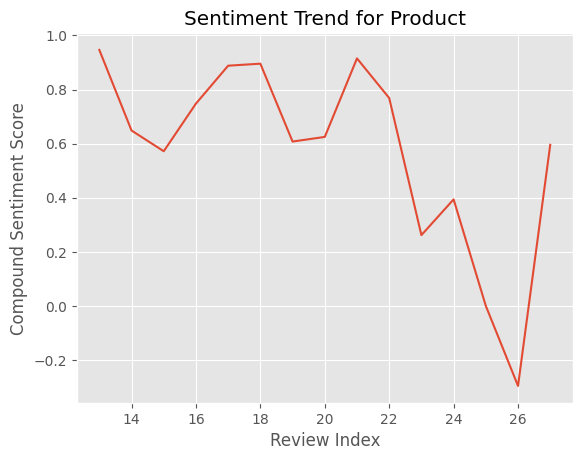

In [23]:
# Example: Plotting sentiment scores for a specific product
product_data = vaders[vaders['ProductId'] == 'B001GVISJM']
sns.lineplot(x=product_data.index, y=product_data['compound'])
plt.title('Sentiment Trend for Product')
plt.xlabel('Review Index')
plt.ylabel('Compound Sentiment Score')
plt.show()

In [ ]:
import plotly.express as px

# Example: Creating a sentiment dashboard
fig = px.scatter(vaders, x='pos', y='neg', color='ProductId', hover_data=['Text'])
fig.update_layout(title='Sentiment Analysis Dashboard', xaxis_title='Positive Score', yaxis_title='Negative Score')
fig.show()